# Exploring housing data

In [2]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [257]:
training_data = pd.read_csv(r'house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv(r'house-prices-advanced-regression-techniques/test.csv')
#sample = pd.read_csv(r'house-prices-advanced-aregression-techniques/sample_submission.csv')

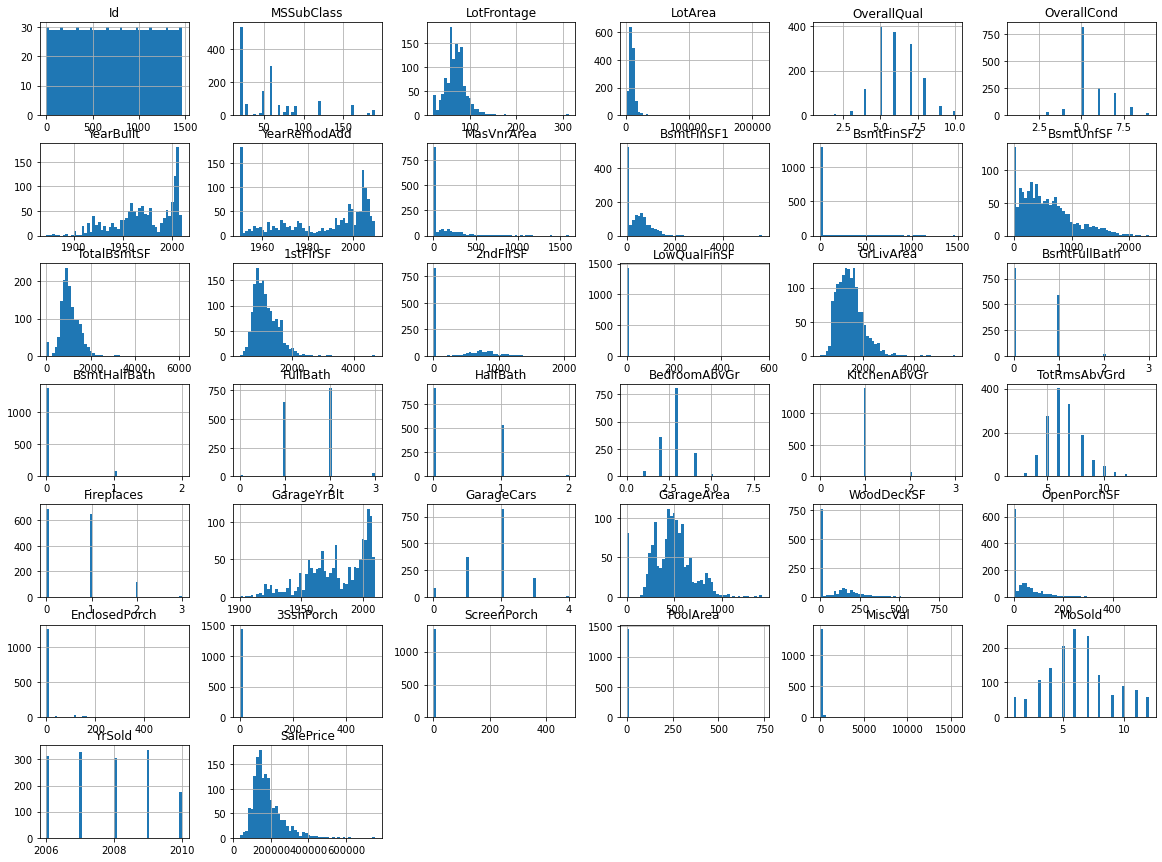

In [258]:
training_data.hist(bins=50, figsize=(20,15))
plt.show()

In [259]:
corr_matrix = training_data.corr()

In [260]:
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [261]:
labels = training_data["SalePrice"].copy()
training_data = training_data.drop("SalePrice", axis=1) 

In [222]:
print(test_data.shape)
print(training_data.shape)

(1459, 80)
(1460, 80)


In [136]:
training_data_num = training_data.select_dtypes(include=[np.number])
training_data_str = training_data.select_dtypes(include=[np.object])

num_attribs = list(training_data_num)
cat_attribs = list(training_data_str)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

training_data_prepared = full_pipeline.fit_transform(training_data)


In [266]:
data_str = training_data.select_dtypes(include=[np.object])
cat_attribs = list(data_str)


encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(training_data[cat_attribs])





def pipeline(df_train,df_test,encoder,dataframe = False):
    
    data_num = df_train.select_dtypes(include=[np.number])
    data_str = df_train.select_dtypes(include=[np.object])

    num_attribs = list(data_num)
    cat_attribs = list(data_str)
    


    num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
    ])
    
#     cat_pipeline = Pipeline([
#         ('trained_encoder',enc)
#     ])

    full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", encoder, cat_attribs),
    ])
    
    df_test_transformed = full_pipeline.fit_transform(df_test)


    df_train_transformed = full_pipeline.transform(df_train)
    
    if dataframe:
        df_transformed = pd.DataFrame.sparse.from_spmatrix(df_transformed)
    
    
    
    print(df_train_transformed.shape,df_test_transformed.shape)
    return df_train_transformed,df_test_transformed

In [267]:
training_data_prepared,test_data_prepared = pipeline(training_data,test_data,encoder)

(1460, 293) (1459, 293)


## Evaluate model

In [268]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(training_data_prepared,labels)

from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(training_data_prepared)
lin_rmse = mean_squared_error(labels, predictions,squared = False)
print(lin_rmse)

21555.445626469398


In [269]:
from sklearn.tree import DecisionTreeRegressor 
tree_reg = DecisionTreeRegressor()
tree_reg.fit(training_data_prepared,labels)
predictions = tree_reg.predict(training_data_prepared)
tree_rmse = mean_squared_error(labels, predictions,squared = False)
print(tree_rmse)

0.0


In [270]:
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor(n_estimators=200,max_features = 4)
forest_reg.fit(training_data_prepared,labels)

RandomForestRegressor(max_features=4, n_estimators=200)

## Using test data

In [271]:
from sklearn.model_selection import cross_val_score

def test_rmse(model):
    scores = cross_val_score(model, training_data_prepared, labels,scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print(f'{model} has a std of {rmse_scores.std()}')

In [272]:
test_rmse(tree_reg)
test_rmse(lin_reg)
test_rmse(forest_reg)

DecisionTreeRegressor() has a std of 6910.557693749992
LinearRegression() has a std of 28443.822123587866
RandomForestRegressor(max_features=4, n_estimators=200) has a std of 7825.292424952201


In [74]:
test_rmse(forest_reg) # 60 , 4

RandomForestRegressor(max_features=4, n_estimators=60) has a score of 7129.840831384809


In [80]:
test_rmse(forest_reg) # 200 , 4

RandomForestRegressor(max_features=4, n_estimators=200) has a score of 8227.571377659277


In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10,100,200], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(training_data_prepared, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 100, 200]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [76]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 200}

In [77]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

40798.851384639376 {'max_features': 2, 'n_estimators': 10}
36892.915925963556 {'max_features': 2, 'n_estimators': 100}
36778.99840645178 {'max_features': 2, 'n_estimators': 200}
39580.76060811763 {'max_features': 4, 'n_estimators': 10}
35331.14390666432 {'max_features': 4, 'n_estimators': 100}
35165.119135077606 {'max_features': 4, 'n_estimators': 200}
38705.5391500271 {'max_features': 6, 'n_estimators': 10}
33719.10620508833 {'max_features': 6, 'n_estimators': 100}
33738.14373196252 {'max_features': 6, 'n_estimators': 200}
34394.98769571247 {'max_features': 8, 'n_estimators': 10}
33053.21473160027 {'max_features': 8, 'n_estimators': 100}
32919.192845405814 {'max_features': 8, 'n_estimators': 200}
45027.53754177071 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
37737.72807096042 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
45462.4739906082 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
37781.76541798631 {'bootstrap': False, 'max_features': 3, 'n_e

In [ ]:
"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [15, 20, 100],

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [15, 20, 100],},
  ]

d = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(d, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(training_data_prepared, labels)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'max_depth': [2, 6, 8],
                          'max_leaf_nodes': [15, 20, 100],
                          'min_samples_leaf': [20, 40, 100],
                          'min_samples_split': [10, 20, 40]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [86]:
best = grid_search.best_params_
tree_reg = DecisionTreeRegressor(max_depth = best['max_depth'],max_leaf_nodes = best['max_leaf_nodes'],min_samples_leaf = best['min_samples_leaf'],min_samples_split = best['min_samples_split'])
tree_reg.fit(training_data_prepared,labels)
test_rmse(tree_reg)

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=100, min_samples_leaf=20,
                      min_samples_split=10) has a score of 7111.861101589085


## submit sample

In [273]:
test_data_prepared

<1459x293 sparse matrix of type '<class 'numpy.float64'>'
	with 116719 stored elements in Compressed Sparse Row format>

In [280]:
predictions = tree_reg.predict(test_data_prepared)
id_list = test_data['Id']

In [285]:
submission = pd.DataFrame(list(zip(id_list, predictions)),
               columns =['Id', 'SalePrice'])

In [289]:
submission.to_csv('house_price_prediction_1.csv',index = False)